### • Business Understanding

•  **Introduction:** The project, involves working with an American retail chain operating across California (CA), Texas (TX), and Wisconsin (WI). This retailer offers a diverse range of products, including hobbies, foods, and household items, across ten stores. The objective is to develop and deploy two distinct machine learning models as APIs to address specific business challenges:

1. Predictive Model: A predictive model to forecast sales revenue for specific items in particular stores on given dates.
2. Forecasting Model: A time-series-based forecasting model to predict total sales revenue across all stores and items for the next seven days.

These models will help optimize inventory, pricing, and decision-making for our retail partner.

•  **Dataset:** To develop and evaluate the models, below datasets are provided:

        - Training Data
        - Evaluation Data
        - Calendar
        - Events
        - Items Price per Week

•  **Business Problem:** The primary business problems that the machine learning models aim to address are as follows:

1. Sales Prediction: The retailer needs to accurately predict the sales revenue for individual items in specific stores for any given date.

2. Sales Forecasting: The retailer seeks to forecast total sales revenue across all stores and items for the next seven days.

This information is crucial for inventory management, pricing strategies, and overall business planning. Our machine learning models aim to address these business challenges by providing precise predictions and forecasts.

The following activitives are performed for this Regression learning task.

• Business Understanding

• Data Understanding

        1] Loading Data
        2] Exploring Data
        3] Combining the training and other datasets

• Data Preparation

        4] Feature Engineering
        5] Features Selection
        6] Splitting Data into Different Sets

• Modeling

        7] Assessing Baseline Performance
        8] Sales Prediction Model: XGBoost Algorithm
        9] Sales Forecasting Model: Prophet Algorithm

• Model Evaluation

        10] Analysing Model Performance

In [60]:
# Importing Python and the necessary libraries
import numpy as np
import pandas as pd

# Importing prophet library for building a time-series Forecasting ML Model
from prophet import Prophet

# Importing dump library from joblib
from joblib import dump

# Importing necessary Data Visualization libraries
import matplotlib.pyplot as plt

# Importing formatting and other required libraries
import sys
import warnings

# Including the project root directory
sys.path.append('/Users/monalipatil/Monali/MDSI-Semester1/Advanced Machine Learning Application/Assignment2/adv_mla_assignment2/')

# Importing class and functions defined to build forecasting machine learning model
from src.models.null import NullAccuracy
from src.models.performance import evaluating_mape_score, evaluating_rmse_score

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
#Ignoring warnings to maintain a clean coding.
warnings.filterwarnings('ignore')

## Building a Forecasting Model

• Loading the training and validation datasets for developing a machine learning model.

In [63]:
# Defining data files path 
# Note: Change this path to the relevant directory
file_url = '/Users/monalipatil/Monali/MDSI-Semester1/Advanced Machine Learning Application/Assignment2/adv_mla_assignment2/'

# Loading the training and validation dataset into a separate pandas dataframe
df_train = pd.read_csv(file_url + '/data/processed/retail_training_dataset.csv')
df_validation = pd.read_csv(file_url + '/data/processed/retail_validation_dataset.csv')

# Loading the calendar events into a pandas dataframe
df_calendar_events = pd.read_csv(file_url + '/data/raw/calendar_events.csv')

• Generating duplicates of the training and validation datasets.

In [64]:
# Creating a copy of the original training and validation datasets
df_train_copied = df_train.copy()
df_validate_copied = df_validation.copy

In [65]:
# Viewing a random observations of the training dataset
df_train.sample(5)

,item_id,store_id,date,event_name,event_type,revenue,day_of_week,month,year,week_of_year
38091476,HOBBIES_1_328,CA_4,2014-06-27,None,None,6.42,4,6,2014,26
43768331,FOODS_3_764,TX_1,2014-12-30,None,None,11.92,1,12,2014,1
2137548,HOBBIES_1_206,CA_2,2011-04-09,None,None,0.00,5,4,2011,14
3954344,FOODS_3_616,TX_3,2011-06-06,None,None,5.76,0,6,2011,23
27496353,HOBBIES_2_056,WI_2,2013-07-16,None,None,0.00,1,7,2013,29


• Constructing the DataFrame by aggregating the 'date' field and computing the cumulative 'revenue' for each date, considering all stores and states.

In [66]:
# Aggregating the DataFrame based on the 'date' attribute and calculating the total 'revenue' for each date across all stores and states.
df_train = df_train.groupby('date')['revenue'].sum().reset_index()
df_validation = df_validation.groupby('date')['revenue'].sum().reset_index()

• Verifying the attributes and their datatypes after aggregating and calculating the cumulative 'revenue'.

In [67]:
# Checking the attributes and their datatypes after aggregating and calculating the cumulative 'revenue'
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     1433 non-null   object 
 1   revenue  1433 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.5+ KB


In [68]:
# Checking the few initial records of the training dataset
df_train.head()

,date,revenue
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


• Renaming the labels of the attributes intended for use in the Prophet forecasting model.

In [69]:
# Modifying the names of the attributes intended for use in the Prophet forecasting model
df_train = df_train.rename(columns={'date':'ds', 'revenue':'y'})
df_validation = df_validation.rename(columns={'date':'ds', 'revenue':'y'})

In [70]:
# Checking the few initial records of the training dataset after lables renaming
df_train.head()

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


• Examining the training dataset.

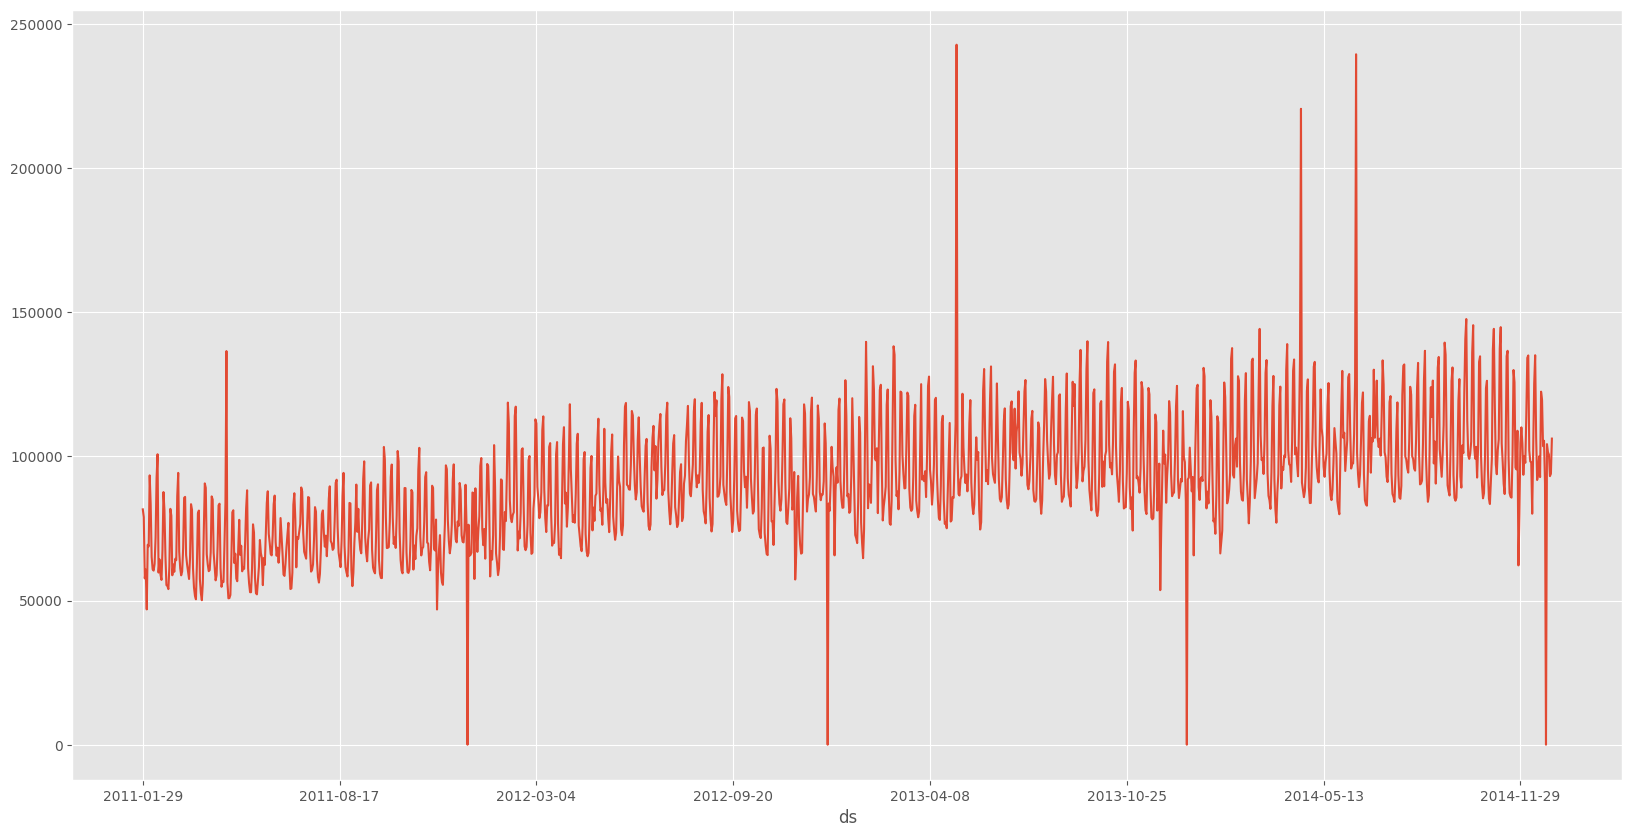

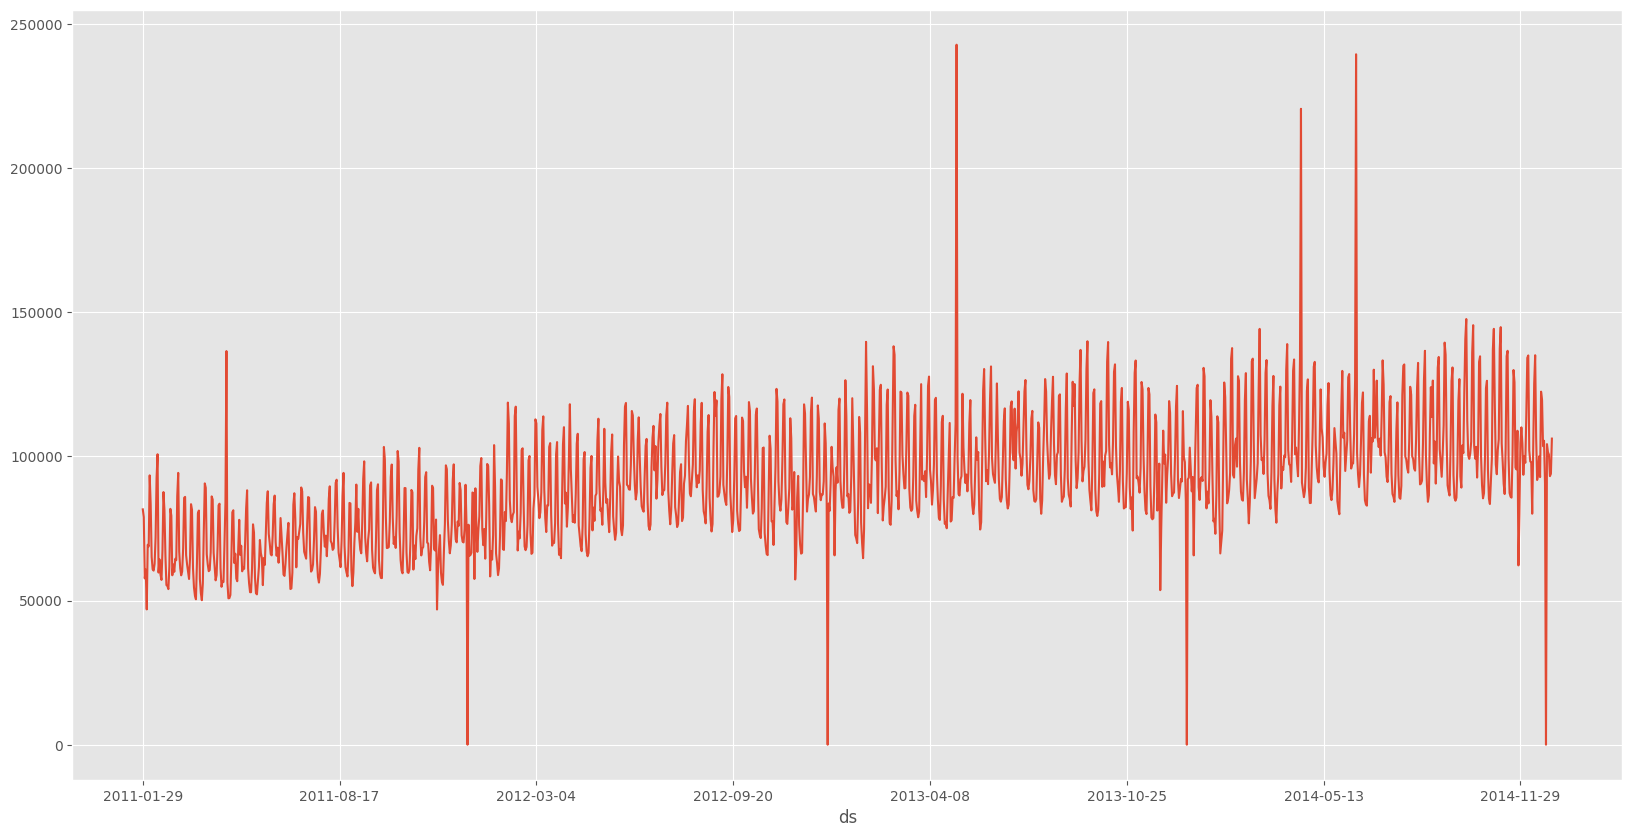

In [71]:
# Setting the size of the plot figure and use the 'ggplot' style
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Creating a time series plot using the 'y' attribute with 'ds' as the index
df_train.set_index('ds').y.plot().figure

• Inspecting the initial records in the calendar events dataset.

In [72]:
# Checking the initial observations of the calendar events dataset
df_calendar_events.head()

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious


• Verifying the unique 'event_names' and 'event_type' in the calendar events dataset.

In [73]:
# Checking the unique 'event_names' of the calendar events dataset
print(df_calendar_events['event_name'].unique()) 

['SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'Easter' 'OrthodoxEaster' 'Pesach End'
 'Cinco De Mayo' "Mother's day" 'MemorialDay' 'NBAFinalsStart'
 'NBAFinalsEnd' "Father's day" 'IndependenceDay' 'Ramadan starts'
 'Eid al-Fitr' 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha'
 'VeteransDay' 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear'
 'OrthodoxChristmas' 'MartinLutherKingDay']


In [74]:
# Checking the unique 'event_type' of the calendar events dataset
print(df_calendar_events['event_type'].unique()) 

['Sporting' 'Cultural' 'National' 'Religious']


• Generating a DataFrame called 'df_events' to specify holidays for the time series model.

In [75]:
# Creating a DataFrame named 'df_events' to define holidays for the time series model
# Here, 'calendar_events' is used as the holiday name, and the 'ds' column is set to the date values from calendar events dataset
# The 'lower_window' and 'upper_window' are set to 0, indicating that the holidays occur only on the specific date
df_events = pd.DataFrame({'holiday': 'calendar_events', 
                          'ds': pd.to_datetime(df_calendar_events['date']), 
                          'lower_window': 0, 
                          'upper_window': 0,})

• Verifying the attributes and their datatypes after building the holidays dataset for the time series model.

In [76]:
# Checking the attributes and their datatypes after building the holidays dataset for the time series model
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   holiday       167 non-null    object        
 1   ds            167 non-null    datetime64[ns]
 2   lower_window  167 non-null    int64         
 3   upper_window  167 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.3+ KB


In [77]:
# Checking the few initial records of the holidays dataset for the time series model
df_events.head()

,holiday,ds,lower_window,upper_window
0,calendar_events,2011-02-06,0,0
1,calendar_events,2011-02-14,0,0
2,calendar_events,2011-02-21,0,0
3,calendar_events,2011-03-09,0,0
4,calendar_events,2011-03-16,0,0


### • Modeling

#### 7] Assessing Baseline Performance

In [79]:
# Creating a instance of the NullAccuracy class 
baseline = NullAccuracy()

# Invoking a method to evaluate the baseline performance score
y_base = baseline.fit_predict(df_train['y'])

In [80]:
# Calculating the baseline performance scores MAPE and RMSE   
print('Performance Scores:') 
print('Baseline MAPE score:', evaluating_mape_score(df_train['y'], pd.Series(y_base.flatten())))
print('Baseline RMSE score:', evaluating_rmse_score(df_train['y'], pd.Series(y_base.flatten())))

Performance Scores:
Baseline MAPE score: 898.0839
Baseline RMSE score: 21278.1704


#### 9] Developing a Forecasting time-series Model

• Instantiating instance of the Phophet time-series algorithm for revenue forcasting.

In [81]:
# Generating a 'forecast_model' instance of Phophet model with daily and weekly seasonality 
phophet_model = Prophet(holidays=df_events, weekly_seasonality=True, daily_seasonality=True)

• Fitting the Prophet model with the training data.

In [82]:
# Training the Phophet forecasting model with the training dataset
phophet_model.fit(df_train)

02:09:15 - cmdstanpy - INFO - Chain [1] start processing
02:09:15 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
# Checking the few initial records of the training dataset
df_train.head()

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


In [102]:
obs = pd.DataFrame(df_train.iloc[0]).transpose()
forecasted_revenue = phophet_model.predict(obs)
print(f"For 2011-01-29, forecasted sales revenue: ${forecasted_revenue['yhat'].item():.4f} and actual sales revenue: $81650.61")

For 2011-01-29, forecasted sales revenue: $81162.4143 and actual sales revenue: $81650.61


In [110]:
forecasted_revenue = phophet_model.predict(pd.DataFrame({'ds': ['2011-01-31']}))
print(f"For 2011-01-31, forecasted sales revenue: ${forecasted_revenue['yhat'].item():.4f} and actual sales revenue: $57706.91")

For 2011-01-31, forecasted sales revenue: $58768.1592 and actual sales revenue: $57706.91


### • Model Evaluation

#### 10] Analysing Model Performance

• Assessing the performance measures of the forecasting model employing the Phophet Algorithm.

In [86]:
# Predicting from the trained model for the training dataset storing the results in 'y_train_predicted'
y_train_predicted = phophet_model.predict(pd.DataFrame(df_train['ds']))

In [87]:
# Calculating the Phophet model's performance scores MAS and RMSE - training dataset
print('Performance Scores of the forecasting model employing Phophet Algorithm:') 
print('Training MAPE score:', evaluating_mape_score(df_train['y'], y_train_predicted['yhat']))
print('Training RMSE score:', evaluating_rmse_score(df_train['y'], y_train_predicted['yhat']))

Performance Scores of the forecasting model employing Phophet Algorithm:
Training MAPE score: 821.0444
Training RMSE score: 10442.7834


In [88]:
# Predicting from the trained model for the validation dataset and storing the results in 'y_validate_predicted'
y_validate_predicted = phophet_model.predict(pd.DataFrame(df_validation['ds']))

In [89]:
# Calculating the Phophet model's performance scores MAS and RMSE - validation dataset
print('Performance Scores of the forecasting model employing Phophet Algorithm:') 
print('Validation MAPE score:', evaluating_mape_score(df_validation['y'], y_validate_predicted['yhat']))
print('Validation RMSE score:', evaluating_rmse_score(df_validation['y'], y_validate_predicted['yhat']))

Performance Scores of the forecasting model employing Phophet Algorithm:
Validation MAPE score: 7.0549
Validation RMSE score: 9861.6278


• Saving the trained Phophet forecasting model into the models directoy named as a 'phophetrevenue_forecastingregressor.joblib'.

In [90]:
# Storing the trained phophet revenue forecasting model in the models directory and naming the file as 'forecasting_revenue_regressor.joblib'
dump(phophet_model, '../../models/forecasting/phophetrevenue_forecastingregressor.joblib')

['../../models/forecasting/phophetrevenue_forecastingregressor.joblib']